In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import string
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
nltk.download('punkt')

import numpy as np
import pandas as pd
import re

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize

from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
import torch.optim as optim

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/archive/train.csv")
val_df = pd.read_csv("/content/drive/MyDrive/archive/validation.csv")
test_df = pd.read_csv("/content/drive/MyDrive/archive/test.csv")

In [ ]:
torch.manual_seed(2642136858593228247)

In [ ]:
# print(torch.initial_seed())

In [ ]:
def vectorise(texts, w2v_model, max_length=40):
    vector_size = w2v_model.vector_size
    texts_vec = []

    words = set(w2v_model.index_to_key)

    for text in texts:
        sentence_vectors = []

        # 遍历句子中的每个词，最多到 max_length
        for word in text[:max_length]:
          if word in words:
              # 如果词在模型的词汇表中，添加它的向量
              sentence_vectors.append(w2v_model[word])
          else:
              # 否则，添加零向量
              sentence_vectors.append(np.zeros(vector_size))

        # 如果句子长度小于 max_length，用零向量填充剩余的部分
        for _ in range(max_length - len(sentence_vectors)):
            sentence_vectors.append(np.zeros(vector_size))

        # 将句子的词向量列表添加到结果列表中
        texts_vec.append(sentence_vectors)

    # 将列表转换为三维 NumPy 数组
    # 结果形状为 (句子数量, max_length, vector_size)
    return np.array(texts_vec)

In [ ]:
def process_strings(strings):
    strings = re.sub(r'\[[0-9, ]*\]', '', strings)
    strings = re.sub(r'^...', '... ', strings)
    strings = word_tokenize(strings.lower())
    return strings

def process_names(sectionNames):
    returned = []
    for case in sectionNames:
        print(case)
        case = case.lower()
        case = re.sub(r'^[0-9.]{2,}', '', case)
        returned.append(case)
    return returned

In [ ]:
def preprocess_sectionName(sectionName):
    sectionName = str(sectionName)
    newSectionName = sectionName.lower()
    # sectionName_split = newSectionName.split()
    # pattern = r'\d+'

    # if re.search(pattern, sectionName_split[0]):
    #     if len(sectionName_split) > 1:
    #         newSectionName = " ".join(sectionName_split[1:])
    #     else:
    #         newSectionName = None

    if newSectionName != None:
        if "introduction" in newSectionName or "preliminaries" in newSectionName:
            newSectionName = "introduction"
        elif "result" in newSectionName or "finding" in newSectionName:
            newSectionName = "results"
        elif "method" in newSectionName or "approach" in newSectionName:
            newSectionName = "method"
        elif "discussion" in newSectionName:
            newSectionName = "discussion"
        elif "background" in newSectionName:
            newSectionName = "background"
        elif "experiment" in newSectionName or "setup" in newSectionName or "set-up" in newSectionName or "set up" in newSectionName:
            newSectionName = "experiment"
        elif "related work" in newSectionName or "relatedwork" in newSectionName or "prior work" in newSectionName or "literature review" in newSectionName:
            newSectionName = "related work"
        elif "evaluation" in newSectionName:
            newSectionName = "evaluation"
        elif "implementation" in newSectionName:
            newSectionName = "implementation"
        elif "conclusion" in newSectionName:
            newSectionName = "conclusion"
        elif "limitation" in newSectionName:
            newSectionName = "limitation"
        elif "appendix" in newSectionName:
            newSectionName = "appendix"
        elif "future work" in newSectionName or "extension" in newSectionName:
            newSectionName = "appendix"
        elif "analysis" in newSectionName:
            newSectionName = "analysis"
        else:
            newSectionName = "unspecified"

        return newSectionName

In [ ]:
train_df["sectionName"] = train_df["sectionName"].apply(preprocess_sectionName)
val_df["sectionName"] = val_df["sectionName"].apply(preprocess_sectionName)
test_df["sectionName"] = test_df["sectionName"].apply(preprocess_sectionName)

In [ ]:
sec_name_mapping = {"discussion": 0, "introduction": 1, "unspecified": 2, "method": 3,
                    "results": 4, "experiment": 5, "background": 6, "implementation": 7,
                    "related work": 8, "analysis": 9, "conclusion": 10, "evaluation": 11,
                    "appendix": 12, "limitation": 13}

In [ ]:
train_df_clean = train_df[["string", "sectionName", "label"]]
val_df_clean = val_df[["string", "sectionName", "label"]]
test_df_clean = test_df[["string", "sectionName", "label"]]

In [ ]:
train_sec = train_df_clean['sectionName'].tolist()
train_sec = [sec_name_mapping[label] for label in train_sec]
train_text = train_df_clean['string'].apply(process_strings)
train_labels = train_df_clean["label"]

val_sec = val_df_clean['sectionName'].tolist()
val_sec = [sec_name_mapping[label] for label in val_sec]
val_text = val_df_clean['string'].apply(process_strings)
val_labels = val_df_clean["label"]

test_sec = test_df_clean['sectionName'].tolist()
test_sec = [sec_name_mapping[label] for label in test_sec]
test_text = test_df_clean['string'].apply(process_strings)
test_labels = test_df_clean["label"]

In [ ]:
from gensim.models import KeyedVectors

# Specify the file path to the downloaded Word2Vec model
model_file_path = '/content/drive/MyDrive/archive/GoogleNews-vectors-negative300.bin'

# Load the Word2Vec model
word2vec_model = KeyedVectors.load_word2vec_format(model_file_path, binary=True)

In [ ]:
print(train_df_clean['string'])

0       However, how frataxin interacts with the Fe-S ...
1       In the study by Hickey et al. (2012), spikes w...
2       The drug also reduces catecholamine secretion,...
3       By clustering with lowly aggressive close kin ...
4       Ophthalmic symptoms are rare manifestations of...
                              ...                        
8189    Importantly, the results of Pascalis et al. (2...
8190    As suggested by Nguena et al, there is a need ...
8191    Skeletal muscle is also a primary site of dise...
8192    ACTIVATION OF TRANSCRIPTION FACTORS Roles for ...
8193    Most studies focused on the relation between b...
Name: string, Length: 8194, dtype: object


In [ ]:
print(train_text)

0       [..., ever, ,, how, frataxin, interacts, with,...
1       [..., the, study, by, hickey, et, al, ., (, 20...
2       [..., drug, also, reduces, catecholamine, secr...
3       [..., clustering, with, lowly, aggressive, clo...
4       [..., thalmic, symptoms, are, rare, manifestat...
                              ...                        
8189    [..., ortantly, ,, the, results, of, pascalis,...
8190    [..., suggested, by, nguena, et, al, ,, there,...
8191    [..., letal, muscle, is, also, a, primary, sit...
8192    [..., ivation, of, transcription, factors, rol...
8193    [..., t, studies, focused, on, the, relation, ...
Name: string, Length: 8194, dtype: object


In [ ]:
train_text = vectorise(train_text, word2vec_model)
val_text = vectorise(val_text, word2vec_model)
test_text = vectorise(test_text, word2vec_model)

In [ ]:
import torch
import torch.nn as nn

In [ ]:
# for train set
train_text = torch.tensor(train_text, dtype=torch.float32)
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_text = torch.tensor(val_text, dtype=torch.float32)
val_y = torch.tensor(val_labels.tolist())

# for test set
test_text = torch.tensor(test_text, dtype=torch.float32)
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_text, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_text, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes

        # Bidirectional LSTM
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)
        #, bidirectional=True

        # Unidirectional LSTM
        # self.lstm = nn.LSTM(hidden_size * 2, hidden_size, num_layers, batch_first=True)

        # Output layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Forward pass through Bidirectional LSTM
        out, _ = self.bilstm(x)

        # Forward pass through Unidirectional LSTM
        # out, _ = self.lstm(out)

        # Compute attention scores
        attention_scores = self.attention(out).squeeze(-1)

        # Apply softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=1)

        # Compute the weighted sum of LSTM outputs using attention weights
        weighted_sum = torch.sum(out * attention_weights.unsqueeze(-1), dim=1)

        # Reshape the output to [batch_size, sequence_length, hidden_size]
        # out = out[:, -1, :]

        # Output layer
        out = self.fc(weighted_sum)
        return out, attention_weights

# Parameters
input_size = 300  # Input size
hidden_size = 40  # Number of neurons in each LSTM layer
num_layers = 1  # Number of LSTM layers
num_classes = 3  # Number of output classes

# # Create the model
# model = BiLSTM(input_size, hidden_size, num_layers, num_classes)
# print(model)

Epoch 1/10, Train Loss: 0.7973, Val Loss: 0.6125, Val Acc: 0.7631
Epoch 2/10, Train Loss: 0.5440, Val Loss: 0.5433, Val Acc: 0.7817
Epoch 3/10, Train Loss: 0.4919, Val Loss: 0.5197, Val Acc: 0.7991
Epoch 4/10, Train Loss: 0.4637, Val Loss: 0.4817, Val Acc: 0.8210
Epoch 5/10, Train Loss: 0.4437, Val Loss: 0.4659, Val Acc: 0.8144
Epoch 6/10, Train Loss: 0.4196, Val Loss: 0.4853, Val Acc: 0.8035
Epoch 7/10, Train Loss: 0.4078, Val Loss: 0.4752, Val Acc: 0.8155
Epoch 8/10, Train Loss: 0.3906, Val Loss: 0.4801, Val Acc: 0.8231
Epoch 9/10, Train Loss: 0.3858, Val Loss: 0.4603, Val Acc: 0.8221
Epoch 10/10, Train Loss: 0.3705, Val Loss: 0.4766, Val Acc: 0.8090


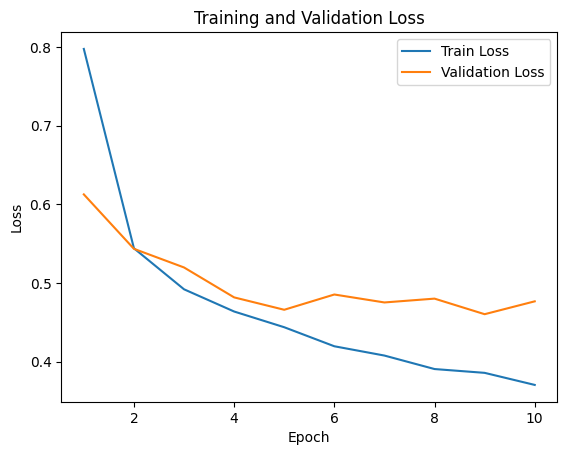

In [ ]:
def train(model, train_loader, criterion, optimizer):
    model.train()  # Set the model to train mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        # print(inputs.size())
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def evaluate(model, val_loader, criterion):
    model.eval()  # Set the model to eval mode
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(val_loader), correct / total

def predict(model, test_loader):
    model.eval()  # Set the model to eval mode
    predictions = []
    with torch.no_grad():
        for inputs in test_loader:
            outputs, _ = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    return predictions

# Example usage
# Assuming train_loader, val_loader, and test_loader are DataLoader objects

import pickle

# with open('unilstm.pkl', 'rb') as f:
#     model = pickle.load(f)
model = BiLSTM(input_size, hidden_size, num_layers, num_classes)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_dataloader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
def predict(model, inputs):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs, _ = model(inputs)  # Forward pass
        print(outputs.shape)
        predicted = torch.max(outputs, 1)[1]  # Get the predicted class indices
        print(len(predicted))
    return predicted  # Move the predicted tensor to CPU and convert to numpy arr

In [ ]:
preds= predict(model, test_text)

torch.Size([1859, 3])
1859


In [ ]:
test_df_clean["pred"] = preds
test_df_clean.to_csv("/content/drive/MyDrive/archive/unilstm+attention.csv")

<ipython-input-45-6bb99cbc176f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_clean["pred"] = preds


In [ ]:
# # model's performance
# preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

micro_f1_score = f1_score(test_y, preds, average='micro')
print(micro_f1_score)

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       604
           1       0.85      0.84      0.85       996
           2       0.72      0.76      0.74       259

    accuracy                           0.82      1859
   macro avg       0.80      0.81      0.80      1859
weighted avg       0.82      0.82      0.82      1859

0.8219472834857451


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y, preds)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[491 100  13]
 [ 92 839  65]
 [ 11  50 198]]


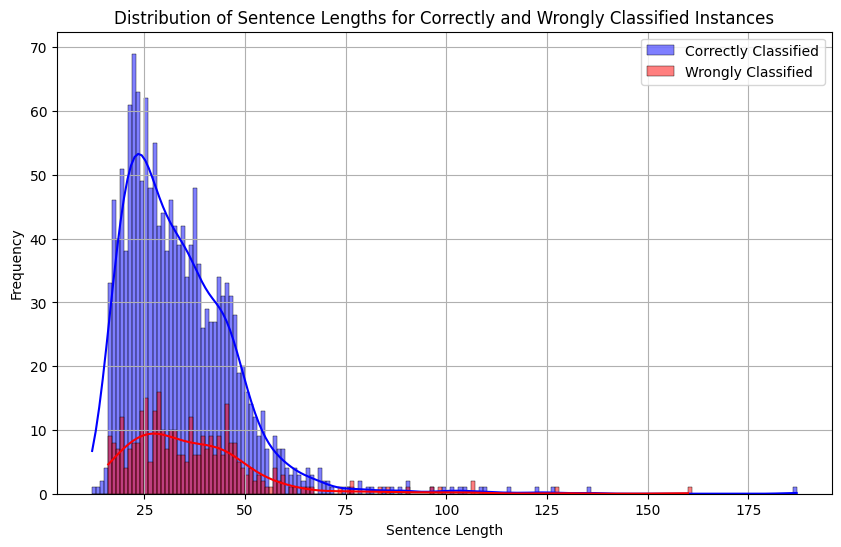

In [ ]:
import seaborn as sns
df = pd.read_csv("/content/drive/MyDrive/archive/unilstm+attention.csv")

# Calculate sentence lengths
df['sentence_length'] = df['string'].apply(lambda x: len(x.split()))

# Filter correctly classified instances
correctly_classified = df[df['label'] == df['pred']]

# Filter wrongly classified instances
wrongly_classified = df[df['label'] != df['pred']]

# Plot distribution of sentence lengths for correctly classified instances
plt.figure(figsize=(10, 6))
sns.histplot(data=correctly_classified, x='sentence_length', bins=range(min(df['sentence_length']), max(df['sentence_length']) + 1), kde=True, color='blue', label='Correctly Classified')
sns.histplot(data=wrongly_classified, x='sentence_length', bins=range(min(df['sentence_length']), max(df['sentence_length']) + 1), kde=True, color='red', label='Wrongly Classified')
plt.title('Distribution of Sentence Lengths for Correctly and Wrongly Classified Instances')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
summary_correct = correctly_classified['sentence_length'].describe()

# Get four-number summary for sentence length of wrongly classified instances
summary_wrong = wrongly_classified['sentence_length'].describe()

print("Four-Number Summary for Correctly Classified Instances:")
print(summary_correct)
print("\nFour-Number Summary for Wrongly Classified Instances:")
print(summary_wrong)

Four-Number Summary for Correctly Classified Instances:
count    1528.000000
mean       33.534031
std        14.497978
min        12.000000
25%        23.000000
50%        31.000000
75%        41.000000
max       187.000000
Name: sentence_length, dtype: float64

Four-Number Summary for Wrongly Classified Instances:
count    331.000000
mean      36.450151
std       17.224008
min       16.000000
25%       25.000000
50%       33.000000
75%       44.000000
max      160.000000
Name: sentence_length, dtype: float64


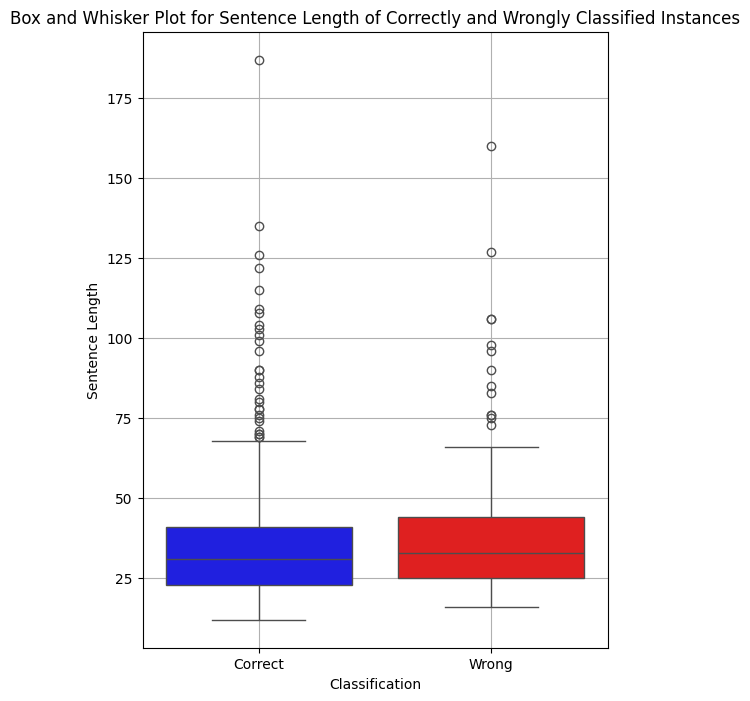

In [ ]:
combined_data = pd.concat([correctly_classified.assign(Classified='Correct'), wrongly_classified.assign(Classified='Wrong')])

# Plot box and whisker diagram for sentence length of both correctly and wrongly classified instances
plt.figure(figsize=(6, 8))
sns.boxplot(data=combined_data, x='Classified', y='sentence_length', hue='Classified', palette={'Correct': 'blue', 'Wrong': 'red'})
plt.title('Box and Whisker Plot for Sentence Length of Correctly and Wrongly Classified Instances')
plt.xlabel('Classification')
plt.ylabel('Sentence Length')
plt.grid(True)
plt.show()

In [ ]:
import pickle

# Assuming you have a model named 'model' that you want to save
# Replace 'model' with the name of your actual model

# Save the model to a file
with open('unilstm+attention.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved successfully as 'model.pickle'")

Model saved successfully as 'model.pickle'


In [ ]:
from sklearn.manifold import TSNE

In [ ]:
print(test_df_clean['string'].apply(process_strings))

0       [..., pel, ,, as, well, as, x10, ,, upc, ,, co...
1       [..., addition, ,, the, result, of, the, prese...
2       [..., eral, instruments, that, more, specifica...
3       [..., anotypic, hippocampal, slice, cultures, ...
4       [..., ivated, pbmc, are, the, basis, of, the, ...
                              ...                        
1854    [..., itionally, ,, no, sex, differences, were...
1855    [..., t, (, 40gy, in, 20, fractions, ), along,...
1856    [..., data, obtained, from, this, crosssection...
1857    [..., itionally, ,, encapsulated, spheroids, m...
1858    [..., dosages, of, l-nmma, and, indomethacin, ...
Name: string, Length: 1859, dtype: object


Organotypic hippocampal slice cultures
Interface hippocampal slice cultures were prepared as described previously (Stoppini et al. 1991; Boudkkazi et al. 2007; Debanne et al. 2008).
torch.Size([1, 40, 300])
torch.Size([1, 40, 40])
torch.Size([40, 40])
34


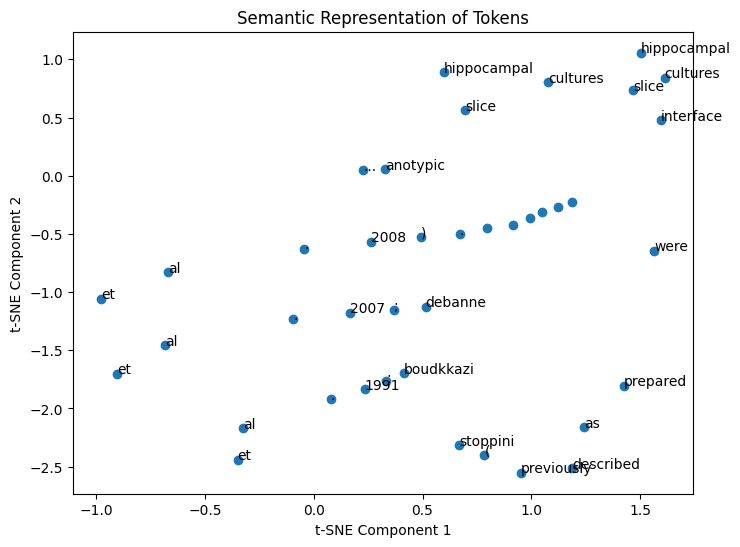

In [ ]:
idx = 3
print(test_df_clean['string'][idx])
input_sequence = (test_df_clean['string'].apply(process_strings))[idx]
input_tensor = test_text[idx].reshape(1,40,300)
print(input_tensor.shape)

# Pass input sequence through the LSTM model
with torch.no_grad():
    model.eval()
    hidden_states = model.bilstm(input_tensor)[0]
    print(hidden_states.shape)
    hidden_states = model.bilstm(input_tensor)[0].squeeze(0)  # Extract hidden states

print(hidden_states.shape)
# Apply dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42)
hidden_states_tsne = tsne.fit_transform(hidden_states)

# Plot the semantic representations
plt.figure(figsize=(8, 6))
print(len(input_sequence))
plt.scatter(hidden_states_tsne[:, 0], hidden_states_tsne[:, 1])
for i, token in enumerate(input_sequence[:40]):
  plt.annotate(token, (hidden_states_tsne[i, 0], hidden_states_tsne[i, 1]))
plt.title('Semantic Representation of Tokens')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

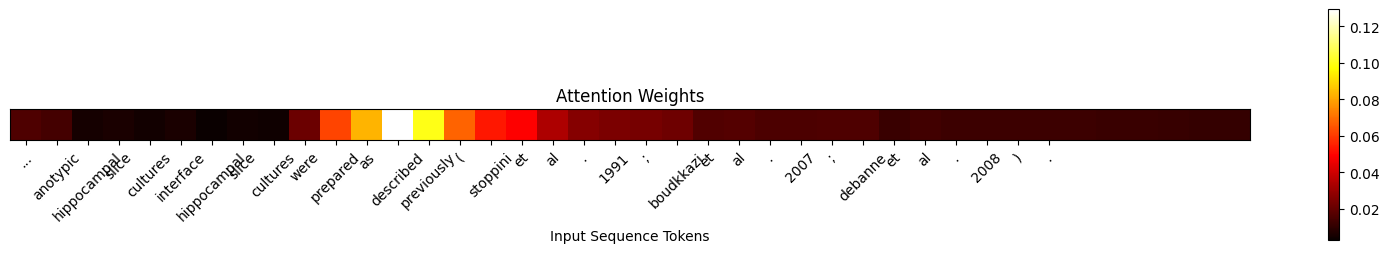

In [ ]:
outputs, attention_weights = model(input_tensor)

def visualize_attention_weights(input_tokens, attention_weights):
    # Plot the attention weights
    plt.figure(figsize=(20, 3))
    plt.imshow(attention_weights.detach().numpy(), cmap='hot', interpolation='nearest')

    # Label the axes with input sequence tokens
    plt.xticks(ticks=range(len(input_tokens)), labels=input_tokens, rotation=45)
    plt.yticks([])
    plt.xlabel('Input Sequence Tokens')
    plt.title('Attention Weights')
    plt.colorbar()
    plt.show()

# Visualize the attention weights
visualize_attention_weights(input_sequence, attention_weights)